In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def load_ads_data(filepath: str) -> pd.DataFrame:
    df = pd.read_json(filepath, lines=True)
    df['run_start_date'] = pd.to_datetime(df['run_start_date'], errors='coerce')
    df['run_end_date'] = pd.to_datetime(df['run_end_date'], errors='coerce')
    df['scraped_at'] = pd.to_datetime(df['scraped_at'], errors='coerce')
    df['normalized_at'] = pd.to_datetime(df['normalized_at'], errors='coerce')
    return df

In [3]:
def calculate_proxy_score(row) -> float:
    # Text length: Ideal range 50–250, peak at ~150
    text = row.get("ad_text") or ""
    text_len = len(text)
    # Two Gaussian-like peaks: one around 50, one around 150
    peak1 = np.exp(-((text_len - 50) ** 2) / (2 * 15 ** 2))
    peak2 = np.exp(-((text_len - 150) ** 2) / (2 * 30 ** 2))
    # Combine both scores and normalize to 0–1
    text_len_score = np.clip(max(peak1, peak2), 0, 1)

    media_type = row['media_mix']
    media_mix_score = {
        "video-only": 1.0,
        "both": 0.8,
        "image-only": 0.6,
        "none": 0.0
    }.get(media_type, 0.0)

    is_active_score = 1.0 if row.get('is_active') else 0.0

    # Cap duration to 36 hours before scoring
    duration = row.get("run_duration_hours") or 0
    capped_duration = min(duration, 36)
    duration_score = np.log1p(capped_duration) / np.log1p(36)

    score = (
        0.35 * text_len_score +
        0.3 * media_mix_score +
        0.2 * is_active_score +
        0.15 * duration_score
    )
    return round(score, 4)

In [4]:
def plot_ad_insights(df):
    df = df.copy()
    df['ad_text_len'] = df['ad_text'].fillna('').apply(len)

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Ad Text Length Distribution
    axes[0, 0].hist(df['ad_text_len'], bins=30, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Ad Text Length Distribution')
    axes[0, 0].set_xlabel('Text Length (chars)')
    axes[0, 0].set_ylabel('Number of Ads')

    # 2. Run Duration (hours)
    sns.histplot(df['run_duration_hours'].dropna(), bins=60, kde=True, ax=axes[0, 1], color='salmon')
    axes[0, 1].set_title('Run Duration Distribution')
    axes[0, 1].set_xlabel('Run Duration (hours)')
    axes[0, 1].set_ylabel('Count')

    # 3. Media Mix
    sns.countplot(data=df, x='media_mix', hue='media_mix', ax=axes[1, 0], palette='viridis')
    axes[1, 0].set_title('Ad Count by Media Type')
    axes[1, 0].set_xlabel('Media Type')
    axes[1, 0].set_ylabel('Count')

    # 4. Top 10 Languages
    top_langs = df['language'].value_counts().nlargest(10)
    sns.barplot(x=top_langs.index, y=top_langs.values, hue=top_langs.index, ax=axes[1, 1], palette='mako')
    axes[1, 1].set_title('Top 10 Ad Languages')
    axes[1, 1].set_xlabel('Language')
    axes[1, 1].set_ylabel('Number of Ads')

    plt.tight_layout()
    plt.show()

In [5]:
data_path = r"../../data/transformed/us_microlearning_ads.jsonl"
df = load_ads_data(data_path)

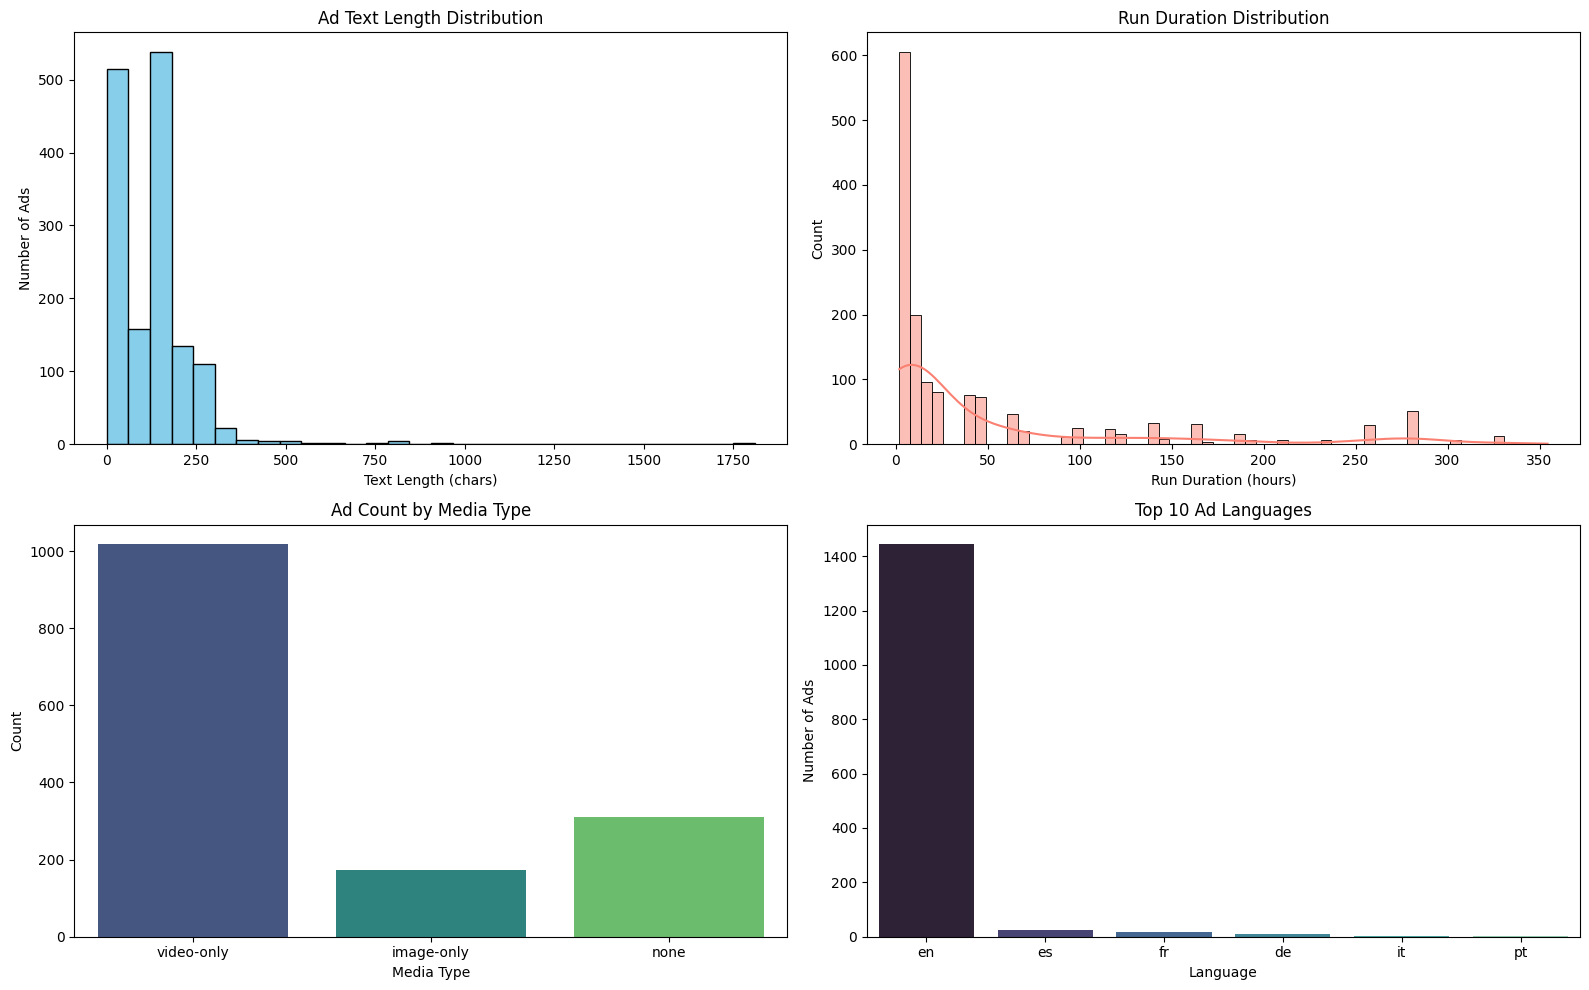

In [6]:
plot_ad_insights(df) 

In [7]:
# Calculate proxy performance score
df['proxy_performance_score'] = df.apply(calculate_proxy_score, axis=1)

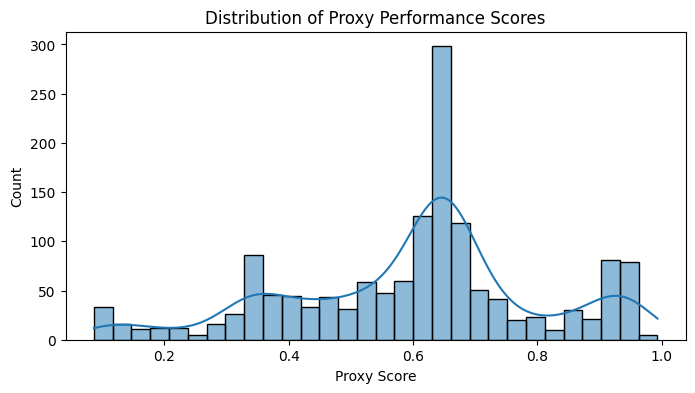

In [8]:
plt.figure(figsize=(8,4))
sns.histplot(df['proxy_performance_score'], bins=30, kde=True)
plt.title("Distribution of Proxy Performance Scores")
plt.xlabel("Proxy Score")
plt.ylabel("Count")
plt.show()

In [12]:
# Top 100 ads
df['ad_text_len'] = df['ad_text'].fillna('').apply(len)
top_ads = df.sort_values(by='proxy_performance_score', ascending=False).head(100)

print("\nTop 100 Ads by Proxy Performance Score:")
print(top_ads[[
    'library_id',
    'advertiser_name',
    'proxy_performance_score',
    'ad_text_len',
    'media_mix',
    'is_active',
    'run_duration_hours'
]])


Top 100 Ads by Proxy Performance Score:
            library_id advertiser_name  proxy_performance_score  ad_text_len  \
470   2183923988727285    Career Voice                   0.9931          156   
469   1532341091260933    Career Voice                   0.9931          156   
467   1974988616372981    Career Voice                   0.9931          156   
471   1261451765682672    Career Voice                   0.9931          156   
244   1072888221114976       BuildWitt                   0.9906          157   
..                 ...             ...                      ...          ...   
907   2231578890593375       Deepstash                   0.9303          130   
628  24240270328918528       Deepstash                   0.9303          130   
432   1497135421466755       Deepstash                   0.9303          130   
438   1062555508883714       Deepstash                   0.9303          130   
436    623195840350945       Deepstash                   0.9303          130   

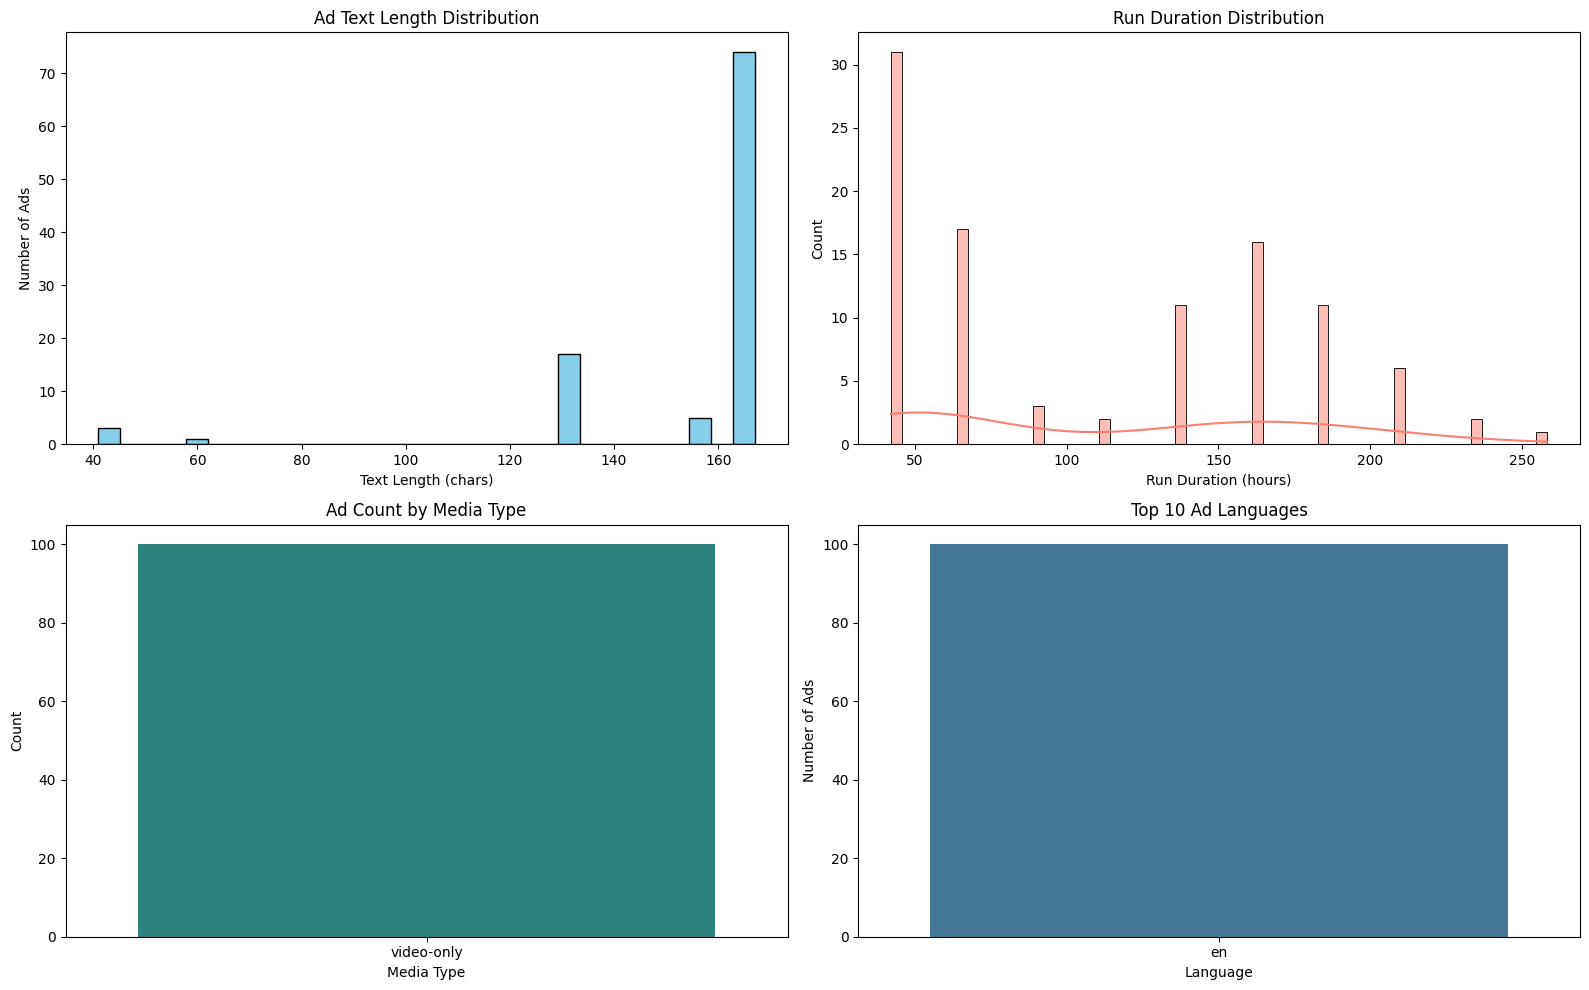

In [13]:
plot_ad_insights(top_ads)